In [1]:
import pandas as pd 
import datetime
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import copy

from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

import data_retreiver as dr

seed = 1

In [2]:
targets = ["ConfirmedCases", "Fatalities"]
features = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities","Median_Age", "Population", "Population_Density"]
features = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities"]

# Create population instance
population = dr.Population("data/Worldometer_Population_Latest.csv")

In [3]:
def append_data(filename):
    df = pd.read_csv(filename)

    missing_country_list = []
    missing_value_median_age = -1
    missing_value_population = 100000
    missing_value_population_density = 1
    median_age_list = []
    population_list = []
    population_density_list = []
    for country in df["Country_Region"]:
        
        ##############
        # Median age
        ##############
        median_age_ = population.get_median_age(country)
        if(median_age_ is None):

            median_age_list.append(missing_value_median_age)

            # Report/ note that this country is not available
            if(country not in missing_country_list):
                missing_country_list.append(country)
        else:
            median_age_list.append(median_age_)
        
        ###############
        # Population
        ###############
        population_ = population.get_population(country)
        if(population_ is None):
            population_list.append(missing_value_population)
        else:
            population_list.append(population_)
        
        #####################
        # Population density
        #####################
        population_density_ = population.get_population_density(country)
        if(population_density_ is None):
            population_density_list.append(missing_value_population_density)
        else:
            population_density_list.append(population_density_)
    
    df["Median_Age"] = median_age_list
    df["Population"] = population_list
    df["Population_Density"] = population_density_list
    df.to_csv("data/appended_data.csv")
    
    return missing_country_list

In [4]:
append_data("data/train.csv")

['Andorra',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 "Cote d'Ivoire",
 'Czechia',
 'Diamond Princess',
 'Dominica',
 'Holy See',
 'Liechtenstein',
 'Monaco',
 'Saint Kitts and Nevis',
 'Saint Vincent and the Grenadines',
 'San Marino']

In [5]:
def preprocess(filename):
    df = pd.read_csv(filename)

    # Create category called Region: country_province
    region_list = ["{}_{}".format(df["Country_Region"][i], df["Province_State"][i]) for i in range(df.shape[0])]
    df["Region"]=region_list

    # Get first day of corona virus for each region
    unique_region_list = list(set(region_list))
    unique_region_list.sort()
    first_date_dict = {}
    for region in unique_region_list:
        mask = df["Region"]==region
        first_ix = np.where(df[mask]["ConfirmedCases"]>0)[0][0] -1    
        first_date = df[mask]["Date"].iloc[first_ix]
        first_date_dict[region] = first_date

    # add column "Days": number of days since the first day of case per each region
    def get_days(dt):
        return dt.days
    dummy = [first_date_dict[region] for region in df["Region"]]
    df["Days"]=(pd.to_datetime(df['Date'])-pd.to_datetime(dummy)).apply(get_days)

    # Add previous confirmed cases and previous fatalities to df
    loc_group=["Region"]
    for target in targets:
        df["prev_{}".format(target)] = df.groupby(loc_group)[target].shift()
        df["prev_{}".format(target)].fillna(0, inplace=True)
    
    # TODO
    df = df[df["Days"]>=-1].copy(deep=True)
    
    # TODO apply log
    for target in targets:
        df[target] = np.log1p(df[target])
        df["prev_{}".format(target)] = np.log1p(df["prev_{}".format(target)])
    
    # ConfirmCases, Fatilies
    X = df[features]
    # TODO use log1p
    Y = df[targets]
    
    return X,Y

In [6]:
X,Y=preprocess("data/appended_data.csv")

In [7]:
def split_train_val(X,Y, unique_region_list,num_of_val_days):
    
    train_ix = []
    val_ix = []
    for region in unique_region_list:
        
        mask = X["Region"]==region
        ix = np.where(mask)[0]
        
        train_ix += list(ix[:-num_of_val_days].flatten())
        val_ix += list(ix[-num_of_val_days:].flatten())
        
    return X.iloc[train_ix],X.iloc[val_ix],Y.iloc[train_ix],Y.iloc[val_ix]    

# IMPORTANT NOTE: We can only use prev_ConfirmedCases for the first day to predict

In [8]:
for target in targets:
    marginal = Marginal().explain_data(X, Y[target],target)
    show(marginal)

<!-- http://127.0.0.1:7156/139619101016584/ -->

<!-- http://127.0.0.1:7156/139619035356408/ -->

## Train and Predict with Explainable Boosting Machine (EBM)

In [9]:
# IMPORTANT NOTE: assuming that X_features is sorted by number of days "Days"
ENFORCE_CONSTRAINT = True
def evaluate_rmse(Y_predicted,Y_true):
    """
    Y_predicted: n-by-d n is the number of data points, d is the number of criteria
    Y_true: n-by-d
    OUTPUT
    d elements
    """
    return np.sqrt(mean_squared_error(Y_predicted,Y_true,multioutput='raw_values'))

def predict(X_features,Y,num_validation_days,num_days_to_predict):
    unique_region_list = list(set(X_features["Region"]))
    unique_region_list.sort()
    print("No of unique region list: {}".format(len(unique_region_list)))
    
    ##################################################################
    # Train and Validation
    ##################################################################
    # Split to train and validation
    X_train,X_val,Y_train,Y_val = split_train_val(X,Y, unique_region_list,num_validation_days)
    
    # Train
    model_ConfirmedCases = ExplainableBoostingRegressor(random_state=seed)
    model_ConfirmedCases.fit(X_train,Y_train["ConfirmedCases"])
    model_Fatalities = ExplainableBoostingRegressor(random_state=seed)
    model_Fatalities.fit(X_train,Y_train["Fatalities"])
    
    # Predict for val
    Y_val_predicted = np.zeros((X_val.shape[0],2))
    
    for i in range(X_val.shape[0]):
        
        if(i==0 or X_val.iloc[i-1]["Region"] != X_val.iloc[i]["Region"]):
            pred_ConfirmedCases = model_ConfirmedCases.predict(X_val.iloc[[i]])[0]
            pred_Fatalities = model_Fatalities.predict(X_val.iloc[[i]])[0]
            
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_val.iloc[[i]]["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = 1.*X_val.iloc[[i]]["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_val.iloc[[i]]["prev_Fatalities"].item()):
                    pred_Fatalities = X_val.iloc[[i]]["prev_Fatalities"].item()
                    
        else:
            X_dummy  = X_val.iloc[[i]].copy(deep=True)
            X_dummy["prev_ConfirmedCases"] = pred_ConfirmedCases
            X_dummy["prev_Fatalities"] = pred_Fatalities
            pred_ConfirmedCases = model_ConfirmedCases.predict(X_dummy)
            pred_Fatalities =model_Fatalities.predict(X_dummy)
        
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = 1.* X_dummy["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                    pred_Fatalities = X_dummy["prev_Fatalities"].item()
                    
        Y_val_predicted[i,0] = pred_ConfirmedCases
        Y_val_predicted[i,1] = pred_Fatalities
        
    # Report validation accuracy
    val_rmse = evaluate_rmse(Y_val,Y_val_predicted)
    
    ##################################################################
    # Train w Full Model and Predict for Test
    ##################################################################
    # Train with full data
    model_full_ConfirmedCases = ExplainableBoostingRegressor(random_state=seed)
    model_full_ConfirmedCases.fit(X_features,Y["ConfirmedCases"])
    model_full_Fatalities = ExplainableBoostingRegressor(random_state=seed)
    model_full_Fatalities.fit(X_features,Y["Fatalities"])
    
    # Predict for test
    Y_test_predicted = np.zeros((len(unique_region_list)*num_days_to_predict,2))
    count=0
    for region in unique_region_list:
        mask = X_features["Region"]==region
        
        prev_ConfirmedCase_ = Y[mask]["ConfirmedCases"].iloc[-1]
        prev_Fatality_ = Y[mask]["Fatalities"].iloc[-1]
        
        #print(prev_ConfirmedCase_,np.exp(prev_ConfirmedCase_)-1, prev_Fatality_, np.exp(prev_Fatality_)-1)
        
        X_dummy = X[mask].iloc[[-1]].copy(deep=True)
        X_dummy["prev_ConfirmedCases"] = prev_ConfirmedCase_
        X_dummy["prev_Fatalities"] = prev_Fatality_
        X_dummy["Days"] = X_dummy["Days"]+1
        
        pred_ConfirmedCases = model_full_ConfirmedCases.predict(X_dummy)
        pred_Fatalities = model_full_Fatalities.predict(X_dummy)
        
        if(ENFORCE_CONSTRAINT):
            if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                pred_ConfirmedCases = X_dummy["prev_ConfirmedCases"].item()
            if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                pred_Fatalities = X_dummy["prev_Fatalities"].item()
                
        Y_test_predicted[count,0] = pred_ConfirmedCases
        Y_test_predicted[count,1] = pred_Fatalities
        count = count+1
        
        for days_ahead in range(2,num_days_to_predict+1):
            
            X_dummy["prev_ConfirmedCases"] = pred_ConfirmedCases
            X_dummy["prev_Fatalities"] = pred_Fatalities
            X_dummy["Days"] = X_dummy["Days"]+1
            pred_ConfirmedCases = model_full_ConfirmedCases.predict(X_dummy)
            pred_Fatalities = model_full_Fatalities.predict(X_dummy)
            
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = X_dummy["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                    pred_Fatalities = X_dummy["prev_Fatalities"].item()
                
            Y_test_predicted[count,0] = pred_ConfirmedCases
            Y_test_predicted[count,1] = pred_Fatalities
            
            count = count+1
      
    assert count==len(Y_test_predicted), "Something wrong"
    

    return unique_region_list,Y_val,Y_val_predicted,val_rmse,Y_test_predicted

In [10]:
num_days_to_predict = 43
num_validation_days = 10
unique_region_list,Y_val,Y_val_predicted,val_rmse,Y_test_predicted=predict(X,Y,num_validation_days,num_days_to_predict)

No of unique region list: 294


In [11]:
# Validation error
print("RMSE for ConfirmedCases and Fatalities: {}".format(val_rmse))

# LOG
# 0.931977, 0.82815295
# After removing days prior to -1
# 0.80376954 0.79612643
# After adding median age:
# 0.8431897  0.80701996]
#-----------------------
# After adding median + population
# 0.91686018 0.8191398
# After adding median + population + population density
# 0.91361809 0.82330433

RMSE for ConfirmedCases and Fatalities: [0.86375747 0.80420493]


In [12]:
# This is the final value ConfirmedCases and Fatalities
# Convert back to linear scale
Y_test_predicted_final = np.exp(Y_test_predicted)-1
Y_val_predicted_final = np.exp(Y_val_predicted)-1

In [13]:
pd.DataFrame(Y_test_predicted_final).to_csv("data/prediction_result.csv")

In [14]:
print(Y_test_predicted_final)
print("*****")
print(len(Y_test_predicted_final))

[[141.87333753   4.14488307]
 [170.56422072   4.41943655]
 [209.70614468   4.4941812 ]
 ...
 [232.25756882   1.51521036]
 [255.05273487   1.51521036]
 [268.73137835   1.51521036]]
*****
12642


## Result Visualization

In [15]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [16]:
# Choose using region_ix
#region_ix = 3
#region = unique_region_list[region_ix]

# Choose using region
region = "Indonesia_nan"
region_ix = unique_region_list.index(region)

USE_LOG_SCALE=False
PLOT_LINE = False
##############################################

mask = X["Region"]==region
N = Y[mask].shape[0]
x_ = np.arange(N+num_days_to_predict)

validation_confirmed_cases = Y_val_predicted_final[region_ix*num_validation_days:(region_ix+1)*num_validation_days,0]
validation_fatalities = Y_val_predicted_final[region_ix*num_validation_days:(region_ix+1)*num_validation_days,1]
predicted_confirmed_cases = Y_test_predicted_final[region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,0]
predicted_fatalities = Y_test_predicted_final[region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,1]

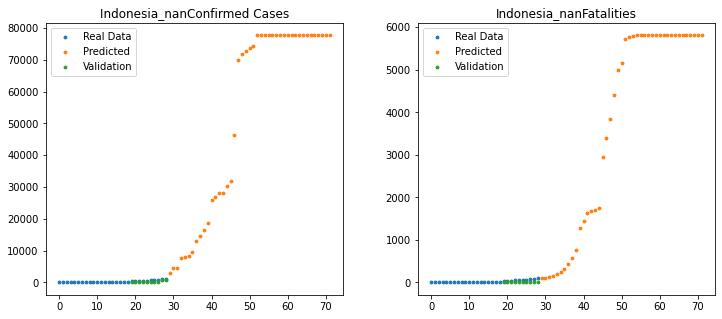

In [17]:
sz = 8
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.25)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
if(USE_LOG_SCALE):
    ax1.set_yscale('log')
    ax2.set_yscale('log')
ax1.scatter(x_[:N],np.exp(Y[mask]["ConfirmedCases"])-1, label="Real Data",s=sz)
ax1.scatter(x_[N:],predicted_confirmed_cases, label="Predicted",s=sz)
ax1.scatter(x_[N-num_validation_days:N],validation_confirmed_cases,label="Validation",s=sz)
if(PLOT_LINE):
    ax1.plot(x_[:N],np.exp(Y[mask]["ConfirmedCases"])-1, label="Real Data")
    ax1.plot(x_[N:],predicted_confirmed_cases, label="Predicted")
    ax1.plot(x_[N-num_validation_days:N],validation_confirmed_cases,label="Validation")
ax1.set_title(region+"Confirmed Cases")
ax1.legend()

ax2.scatter(x_[:N],np.exp(Y[mask]["Fatalities"])-1, label="Real Data",s=sz)
ax2.scatter(x_[N:],predicted_fatalities, label="Predicted",s=sz)
ax2.scatter(x_[N-num_validation_days:N],validation_fatalities,label="Validation",s=sz)
if(PLOT_LINE):
    ax2.plot(x_[:N],np.exp(Y[mask]["Fatalities"])-1, label="Real Data")
    ax2.plot(x_[N:],predicted_fatalities, label="Predicted")
    ax2.plot(x_[N-num_validation_days:N],validation_fatalities,label="Validation")

ax2.set_title(region+"Fatalities")
ax2.legend()


In [18]:
print(predicted_confirmed_cases)

[ 2963.78181618  4526.78126306  4589.47164315  7672.10880035
  7876.57143669  8450.760652    9663.18181876 12989.62645945
 14514.05046806 16358.04343845 18626.57363689 25875.21661291
 26725.81513795 28063.92376923 28063.92376923 30440.98521689
 31770.47018173 46485.87317864 69852.15151072 71688.51517004
 72872.98073503 73754.47392509 74375.12768852 77649.57944455
 77649.57944455 77649.57944455 77649.57944455 77649.57944455
 77649.57944455 77649.57944455 77649.57944455 77649.57944455
 77649.57944455 77649.57944455 77649.57944455 77649.57944455
 77649.57944455 77649.57944455 77649.57944455 77649.57944455
 77649.57944455 77649.57944455 77649.57944455]


## DUMP PLAYGROUND

In [ ]:
def get_unique_region_list(filename):
    df = pd.read_csv(filename)

    # Create category called Region: country_province
    region_list = ["{}_{}".format(df["Country_Region"][i], df["Province_State"][i]) for i in range(df.shape[0])]
    df["Region"]=region_list

    # Get first day of corona virus for each region
    unique_region_list = list(set(region_list))
    unique_region_list.sort()
    
    num_list = [np.sum(np.array(region_list)==region) for region in unique_region_list]
    return np.array(unique_region_list),np.array(num_list)

In [ ]:
unique_region_list, unique_num_list = get_unique_region_list("data/train.csv")

In [ ]:
unique_region_list